In [187]:
%matplotlib inline
import matplotlib
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ma3tplotlib import dates
import plotly.plotly as py
from scipy.stats import gaussian_kde
import operator
import pylab
import pandas as pd

In [233]:
from html import HTML

In [188]:
ACT6_admit = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/ACT6_admit.csv"
CSIU_admit = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/CSIU_admit.csv"
SICU_admit = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/SICU_admit.csv"
MICU_admit = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/MICU_admit.csv"
CCU_admit = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/CCU_admit.csv"
NSIC_admit = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/NSIC_admit.csv"

#erap_fn
ACT6_col = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/ACT6_collection.csv"
CSIU_col = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/CSIU_collection.csv"
SICU_col = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/SICU_collection.csv"
MICU_col = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/MICU_collection.csv"
CCU_col = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/CCU_collection.csv"
NSIC_col = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/NSIC_collection.csv"


In [189]:
def read_erap_table_to_lizcsv (erap_fn, out_fn):
    ''' 
    Read in a file of form: 
    "Patient ID ","Collection Location ","Collection Date ","Sampling Date "
    Ouput in form:
    Mount_Sinai_MRN,SICU_admit_date,hosp_admit_date,Collection_Date,Collection_Date2,...
    '''
    erap_dict = {} # keyed on MRNS
    with open(erap_fn) as f:
        f.readline() # get rid of header
        for l in f:
            ll = l.strip().split(",")
            if len(ll) >= 3:
                mrn = ll[0]
                codate = ll[2]
                #mrn = ll[6][1:-1]
                #codate = ll[4][1:-1]
                erap_dict.setdefault(mrn, []).append(codate)
    fout = open(out_fn, 'w')
    fout.write("Mount_Sinai_MRN,SICU_admit_date,hosp_admit_date,Collection_Date\n")
    for mrn, codates in erap_dict.items():
        fout.write("%s,%s,%s,%s\n" %(mrn,"na","na",",".join(codates)))
    fout.close()
            
    

In [190]:
ACT6_format_fn="/Users/elizabethwebster/ACT6_log_python.csv"
CSIU_format_fn="/Users/elizabethwebster/CSIU_log_python.csv" 
SICU_format_fn="/Users/elizabethwebster/SICU_log_python.csv" 
MICU_format_fn="/Users/elizabethwebster/MICU_log_python.csv" 
CCU_format_fn="/Users/elizabethwebster/CCU_log_python.csv"
NSIC_format_fn="/Users/elizabethwebster/NSIC_log_python.csv" 

read_erap_table_to_lizcsv (ACT6_col, ACT6_format_fn)
read_erap_table_to_lizcsv (CSIU_col, CSIU_format_fn)
read_erap_table_to_lizcsv (SICU_col, SICU_format_fn)
read_erap_table_to_lizcsv (MICU_col, MICU_format_fn)
read_erap_table_to_lizcsv (CCU_col, CCU_format_fn)
read_erap_table_to_lizcsv (NSIC_col, NSIC_format_fn)


In [191]:
def convert_to_python_dates (our_date, delim):
    year,month,day = map(int, our_date.split(delim))
    if year < 1000:
        year+=2000 # corrects for the year been just two digits
    return datetime.date(year, month, day)


In [192]:
def build_mrn_dicts(epic_dump_fn, sampling_data):
    # reading in epic date into a set
    mrnToAdDates ={}
    with open(epic_dump_fn) as f:
        headerline = f.readline()
        for l in f:
            ll = l.strip().split(",")
            mrn,hospit_admit,icu,report_date=ll[0:4]
            mrnToAdDates.setdefault(mrn, set()).add(convert_to_python_dates(report_date, "-"))
    # reading in the sampling_data into 
    mrnToCoDates = {}
    with open(sampling_data) as f:
        headerline = f.readline() # get rid of header
        for l in f:
            ll = l.strip().split(",")
            mrn = ll[0]
            coll_dates = ll[3:]
            for cd in coll_dates:
                if cd != "":
                    mrnToCoDates.setdefault(mrn, set()).add(convert_to_python_dates(cd, "-"))
    return mrnToAdDates, mrnToCoDates

In [193]:
ACT6_adDates, ACT6_coDates = build_mrn_dicts(ACT6_admit,ACT6_format_fn)
CSIU_adDates, CSIU_coDates = build_mrn_dicts(CSIU_admit,CSIU_format_fn)
SICU_adDates, SICU_coDates = build_mrn_dicts(SICU_admit,SICU_format_fn)
MICU_adDates, MICU_coDates = build_mrn_dicts(MICU_admit,MICU_format_fn) 
CCU_adDates, CCU_coDates = build_mrn_dicts(CCU_admit,CCU_format_fn)
NSIC_adDates, NSIC_coDates = build_mrn_dicts(NSIC_admit,NSIC_format_fn) 

In [194]:
def consecutive(a, b):
    return abs((a - b).days) == 1


In [195]:
def identify_readmits (adDates):
    '''
    Identify individuals who have been in the ICU more than once, and remove all but the most recent stay
    from adDates and coDates
    '''
    x=0
    for mrn in adDates:
        dates=sorted(adDates[mrn])
        if all(consecutive(dates[i], dates[i+1]) for i in xrange(len(dates) - 1)):
            if len(dates) == 1: # unique
                x=x+1
        else: # non-consecutive dates
            for i in xrange(len(dates)):
                if dates[i] - dates[i-1] > datetime.timedelta(1):
                    adDates[mrn]=dates[i:len(dates)] #set that MRN as most recent
                    #newmrn="%6d" % random.randint(100000,999999)
                    #print dates[i-1]
                    #print dates[i]
                    #print dates[i+1]
                    #adDates[newmrn]=dates[]
                                                    #Make fake MRN for all others
    return(adDates)

In [196]:
ACT6_adDates = identify_readmits(ACT6_adDates)
CSIU_adDates = identify_readmits(CSIU_adDates)
SICU_adDates = identify_readmits(SICU_adDates)
MICU_adDates = identify_readmits(MICU_adDates)
CCU_adDates = identify_readmits(CCU_adDates)
NSIC_adDates = identify_readmits(NSIC_adDates)

In [197]:
#Remove all adDates before the start date of the 
def removed_before_start(adDates, start):
    '''
    Remove all people who were admitted before the sampling began
    '''
    new = {}
    for person in adDates:
        for date in adDates[person]:
            if date > start:
                new.setdefault(person, set()).add(date)
    return new        

In [198]:
NSIC_start =  datetime.date(2015,11,17)
MICU_start = datetime.date(2015,12,1)
SICU_start = datetime.date(2015,9,14)

#NSIC_start =  datetime.date(2015,12,23)
#MICU_start = datetime.date(2015,12,23)
#SICU_start = datetime.date(2015,12,23)



SICU_adDates = removed_before_start(SICU_adDates,SICU_start)
NSIC_adDates = removed_before_start(NSIC_adDates,NSIC_start)
MICU_adDates = removed_before_start(MICU_adDates, MICU_start)

SICU_coDates = removed_before_start(SICU_coDates,SICU_start)
NSIC_coDates = removed_before_start(NSIC_coDates,NSIC_start)
MICU_coDates = removed_before_start(MICU_coDates, MICU_start)



In [199]:
def find_extreme_date(adDates, maxFlag=False):
    all_dates = set()
    for mrn, dates in adDates.items():
        all_dates = all_dates.union(dates)
    if maxFlag:
        return max(all_dates)
    else:
        return min(all_dates)

In [200]:
end_date = datetime.date.today()
print end_date
start_date = datetime.date(2015, 9, 14)
print start_date

2016-01-13
2015-09-14


In [201]:
def get_patients_sampled_within_x_days (adDates, coDates, x, all_flag=False, plot_flag = False):
    start_date = datetime.date(2015, 9, 14)
    end_date = datetime.date.today()
    #start_date = find_extreme_date(adDates)
    #end_date = find_extreme_date(adDates, maxFlag=True)
    daterange = (end_date-start_date).days # days between first and last date
    date_bins = map(lambda x: datetime.timedelta(x)+start_date, range(x,daterange,x)) # dates that we are checking
    total_patients   = []
    sampled_patients = []
    for bin_end_date in date_bins:
        # first find how many total patients there were
        # and save MRNS
        bin_start_date = bin_end_date-datetime.timedelta(x)
        mrnsInDate = set()
        for mrn, mrnDates in adDates.items():
            # check and see if this person was admitted
            admitDate, exitDate = min(mrnDates), max(mrnDates)
            if all_flag:
                if admitDate <= bin_end_date and exitDate >= bin_start_date:
                    mrnsInDate.add(mrn)    
            elif admitDate <= bin_start_date and exitDate >= bin_end_date:
                mrnsInDate.add(mrn)
        mrnsCollected = set()
        for mrn in mrnsInDate:
            if mrn in coDates:
                mrnCoDates = coDates[mrn]
                # CHANGE THIS TO A BINARY SEARCH!!!!
                for codate in mrnCoDates:
                    if codate >= bin_start_date and codate <= bin_end_date: # check to see if there is a sample within that time
                        mrnsCollected.add(mrn)
                        break
        total_patients.append(len(mrnsInDate))
        sampled_patients.append(len(mrnsCollected))
    return total_patients, sampled_patients, date_bins

In [202]:
def get_mean_length_between_samples(collectionDates):
    meanCol = {}
    for mrn in collectionDates:
        sortedbydate = sorted(collectionDates[mrn])
        if len (sortedbydate) > 1:
            timedeltas = [x - sortedbydate[i - 1] for i, x in enumerate(sortedbydate)][1:]
            average_timedelta = sum(timedeltas, datetime.timedelta(0)) / len(timedeltas)
            meanCol[mrn]=average_timedelta.days
    return meanCol


In [203]:
#ACT6meanbtwcoldates = get_mean_length_between_samples(ACT6_coDates) 
#CSIUmeanbtwcoldates = get_mean_length_between_samples(CSIU_coDates) 
SICUmeanbtwcoldates = get_mean_length_between_samples(SICU_coDates) 
MICUmeanbtwcoldates = get_mean_length_between_samples(MICU_coDates) 
#CCUmeanbtwcoldates = get_mean_length_between_samples(CCU_coDates) 
NSICmeanbtwcoldates = get_mean_length_between_samples(NSIC_coDates) 

a=[]
#a.append(ACT6meanbtwcoldates.values())
#a.append(CSIUmeanbtwcoldates.values())
a.append(SICUmeanbtwcoldates.values())
a.append(MICUmeanbtwcoldates.values())
#a.append(CCUmeanbtwcoldates.values())
a.append(NSICmeanbtwcoldates.values())

#labels = ["ACT6", "CSIU","SICU", "MICU", "CCU", "NSIC"]
labels = ["SICU", "MICU", "NSIC"]

for i in range(len(a)):
    if len(a[i]) > 0:
        r = a[i]
        density = gaussian_kde(r)
        xs = np.linspace(0,15,300)
        density.covariance_factor = lambda : .1
        density._compute_covariance()
        plt.plot(xs,density(xs),label=labels[i],alpha=0.5)
        plt.legend()

plt.xlabel('Mean Number of Days')
plt.ylabel('Frequency')
plt.title('Density of Mean # of Days btw Collection of Samples, For everyone with >1 Sample')
plt.savefig("mean_no_days_btw_collection_of_samples.png", bbox_inches='tight')
plt.close() # Close a figure window


In [204]:
import operator
def fraction_patients_collected(collectionDates,addtoICUdates, op):
    '''
    Get the fractin of patients collected for the number of days spent in the ICU
    '''
    numberdaysinICU = {}
    fracpatientscollected = {}
    daysstay=[]
    ratpat=[]
    for mrn in addtoICUdates:
        diff = max(addtoICUdates[mrn])-min(addtoICUdates[mrn])
        numberdaysinICU[mrn] = diff.days #WIll give length of stay in days for mrn in ICU
    mrnDaysInICUTups = numberdaysinICU.items() # will produce a list of tups [(key, value), (key2, value2)...]
    daysStayed = list(set(numberdaysinICU.values())) # inelegant way to get rid of dups
    daysStayed.sort()
    for i in daysStayed:
        greaterThanI = filter(lambda x: op(x[1], i), mrnDaysInICUTups)
        patientscollected = 0
        totalpatients = len(greaterThanI)
        greaterThanICo = filter(lambda x: x[0] in collectionDates, greaterThanI)
        patientscollected = len(greaterThanICo)
        daysstay.append(i)
        ratpat.append(float(patientscollected)/totalpatients)
    return daysstay, ratpat
    

In [205]:
def number_samples_collected(collectionDates,addtoICUdates, op):
    '''
    Get the average number of samples collected for the number of days spent in the ICU
    '''
    numberdaysinICU = {}
    daysstay=[]
    meannumbcols = []
    for mrn in addtoICUdates:
        diff = max(addtoICUdates[mrn])-min(addtoICUdates[mrn])
        numberdaysinICU[mrn] = diff.days #WIll give length of stay in days for mrn in ICU
    mrnDaysInICUTups = numberdaysinICU.items() # will produce a list of tups [(key, value), (key2, value2)...]
    daysStayed = list(set(numberdaysinICU.values())) # inelegant way to get rid of dups
    daysStayed.sort()
    for i in daysStayed:
        daysstay.append(i)
        numbcoldates = []
        greaterThanI = filter(lambda x: op(x[1], i), mrnDaysInICUTups)
        greaterThanICo = filter(lambda x: x[0] in collectionDates, greaterThanI)
        for mrn,day in greaterThanICo:
            numbcoldates.append(len ( collectionDates[mrn] ))
        meannumbcols.append(np.mean (numbcoldates))
    return daysstay,meannumbcols


In [206]:
#days, meannumbcols = number_samples_collected(coDates, adDates, operator.ge)
ACT6days, ACT6meannumbcols = number_samples_collected(ACT6_coDates,ACT6_adDates, operator.ge) 
CSIUdays, CSIUmeannumbcols = number_samples_collected(CSIU_coDates,CSIU_adDates, operator.ge) 
SICUdays, SICUmeannumbcols = number_samples_collected(SICU_coDates,SICU_adDates, operator.ge) 
MICUdays, MICUmeannumbcols = number_samples_collected(MICU_coDates,MICU_adDates, operator.ge) 
CCUdays, CCUmeannumbcols = number_samples_collected(CCU_coDates,CCU_adDates, operator.ge) 
NSICdays, NSICmeannumbcols = number_samples_collected(NSIC_coDates,NSIC_adDates, operator.ge) 
a=[]
#a.append(ACT6meannumbcols)
#a.append(CSIUmeannumbcols)
a.append(SICUmeannumbcols)
a.append(MICUmeannumbcols)
#a.append(CCUmeannumbcols)
a.append(NSICmeannumbcols)
#labels = ["ACT6", "CSIU", "SICU", "MICU", "CCU", "NSIC"]
labels = ["SICU", "MICU", "NSIC"]
days=[]
#days.append(ACT6days)
#days.append(CSIUdays)
days.append(SICUdays)
days.append(MICUdays)
#days.append(CCUdays)
days.append(NSICdays)
for i in range(len(a)):
    if len(a[i]) > 0:
        r = a[i]
        plt.plot(days[i],a[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Average number of Samples Collected')
plt.xlabel('Stays >= X number of Days')
plt.title('Average number of samples collected for stays >= X number of days')
plt.savefig("avrg_no_samples_stays_greater_that_Xdays.png", bbox_inches='tight')
plt.close() # Close a figure window


In [207]:
#daystay, rat = fraction_patients_collected(coDates, adDates, operator.ge)
ACT6daystay, ACT6rat = fraction_patients_collected(ACT6_coDates,ACT6_adDates, operator.ge) 
CSIUdaystay, CSIUrat = fraction_patients_collected(CSIU_coDates,CSIU_adDates, operator.ge) 
SICUdaystay, SICUrat = fraction_patients_collected(SICU_coDates,SICU_adDates, operator.ge) 
MICUdaystay, MICUrat = fraction_patients_collected(MICU_coDates,MICU_adDates, operator.ge) 
CCUdaystay, CCUrat = fraction_patients_collected(CCU_coDates,CCU_adDates, operator.ge) 
NSICdaystay, NSICrat = fraction_patients_collected(NSIC_coDates,NSIC_adDates, operator.ge) 
a=[]
#a.append(ACT6rat)
#a.append(CSIUrat)
a.append(SICUrat)
a.append(MICUrat)
#a.append(CCUrat)
a.append(NSICrat)
#labels = ["ACT6", "CSIU", "SICU", "MICU", "CCU", "NSIC"]
labels = ["SICU","MICU","NSIC"]
days=[]
#days.append(ACT6daystay)
#days.append(CSIUdaystay)
days.append(SICUdaystay)
days.append(MICUdaystay)
#days.append(CCUdaystay)
days.append(NSICdaystay)
for i in range(len(a)):
    if len(a[i]) > 0:
        r = a[i]
        plt.plot(days[i],a[i],label=labels[i],alpha=0.5)
        plt.legend()


plt.ylabel('Fraction of Patients Collected')
plt.xlabel('Stays >= X number of Days')
plt.title('Fraction of patients collected for stays >= X number of days')
plt.savefig("Fraction_patients_collected.png", bbox_inches='tight')
plt.close() # Close a figure window


In [208]:
#Gives the total number of people that have been in the ICU, the total number that have been sampled and the total number that have not been sampled
def get_agg_stats(addToICUDates, collectionDates, ICU):
    sampled.append(len(collectionDates))
    notsampled.append((len (addToICUDates) - len (collectionDates)))

In [209]:
sampled = []
notsampled = []
#get_agg_stats(ACT6_adDates, ACT6_coDates, "ACT6")
#get_agg_stats(CSIU_adDates, CSIU_coDates, "CSIU")
get_agg_stats(SICU_adDates, SICU_coDates, "SICU")
get_agg_stats(MICU_adDates, MICU_coDates, "MICU") 
#get_agg_stats(CCU_adDates, CCU_coDates, "CCU")
get_agg_stats(NSIC_adDates, NSIC_coDates, "NSIC")

In [289]:
header=['SICU', 'MICU','NSIC']
table1 = open("table1.html",'w')
h = HTML()
t = h.table(border='1')
t.th("ICU")
t.th("Sampled")
t.th("Not Sampled")
for i in range(3):
    r = t.tr
    c = r.td(header[i])
    a = str(sampled[i])
    r.td(a)    
    b = str(notsampled[i])
    r.td(b)    

for line in t:
    table1.write(str(line))

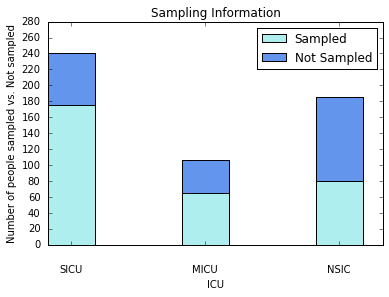

In [268]:
N=len(sampled)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind,sampled, width, color='paleturquoise')
p2 = plt.bar(ind, notsampled, width, color='cornflowerblue',bottom=sampled)

plt.ylabel('Number of people sampled vs. Not sampled')
plt.xlabel("ICU")
plt.title('Sampling Information')
#plt.xticks(ind + width/2., ("ACT6", "CSIU","SICU", "MICU", "CCU", "NSIC"))
plt.xticks(ind + width/2., ("SICU", "MICU","NSIC"))
plt.yticks(np.arange(0, 300, 20))
plt.legend((p1[0], p2[0]), ('Sampled', 'Not Sampled'))
plt.savefig("sampling_dat.png", bbox_inches='tight')
plt.show()
plt.close() # Close a figure window


In [212]:
stoolorswab="/Users/elizabethwebster/Desktop/daily_cdiff_reporting/CDiffTracking/webste01/stoolorswab.txt"
SICU_swab=int()
SICU_stool=int()
MICU_swab=int()
MICU_stool=int()
NSIC_swab=int()
NSIC_stool=int()

with open(stoolorswab) as f:
        f.readline() # get rid of header
        for l in f:
            ll = l.strip().split( )
            if ll[0] == "SICU":
                if ll[1] == "Stools":
                    SICU_stool += 1
                if ll[1] == "Swabs":
                    SICU_swab += 1
            if ll[0] == "MICU":
                if ll[1] == "Stools":
                    MICU_stool += 1
                if ll[1] == "Swabs":
                    MICU_swab += 1
            if ll[0] == "NSIC":
                if ll[1] == "Stools":
                    NSIC_stool += 1
                if ll[1] == "Swabs":
                    NSIC_swab += 1
stool = []
swab = []
stool=[SICU_stool, MICU_stool, NSIC_stool]
swab=[SICU_swab, MICU_swab, NSIC_swab]

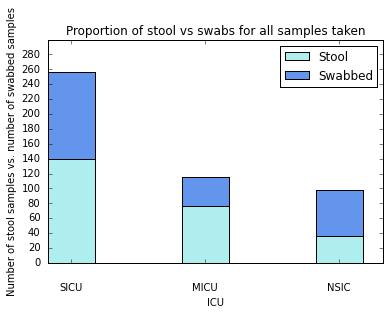

In [270]:
N=len(stool)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind,stool, width, color='paleturquoise')
p2 = plt.bar(ind, swab, width, color='cornflowerblue',bottom=stool)

#p3: lightsteelblue

plt.ylabel('Number of stool samples vs. number of swabbed samples')
plt.xlabel("ICU")
plt.title('Proportion of stool vs swabs for all samples taken')
plt.xticks(ind + width/2., ("SICU","MICU","NSIC"))
plt.yticks(np.arange(0, 300, 20))
plt.legend((p1[0], p2[0]), ('Stool', 'Swabbed'))
plt.savefig("stool_vs_swabbed.png", bbox_inches='tight')
plt.show()
plt.close() # Close a figure window

In [294]:
header=['SICU', 'MICU','NSIC']
table2 = open("table2.html",'w')
h = HTML()
t = h.table(border='1')
t.th("ICU")
t.th("Stool")
t.th("Swab")
for i in range(3):
    r = t.tr
    c = r.td(header[i])
    a = str(stool[i])
    r.td(a)    
    b = str(swab[i])
    r.td(b)    

for line in t:
    table2.write(str(line))

In [215]:
def list_missing(addToICUDates, collectionDates):
    '''
        Print out list of the missing individuals, and the number of days they were in the ICU for
    '''
    missing = {}
    for mrn in addToICUDates:
        if mrn not in collectionDates:
            diff=max(addToICUDates[mrn]) - min(addToICUDates[mrn])
            missing[mrn]=diff.days
    return missing

In [216]:
#ACT6missing = list_missing(ACT6_adDates,ACT6_coDates) 
#CSIUmissing = list_missing(CSIU_adDates,CSIU_coDates) 
SICUmissing = list_missing(SICU_adDates,SICU_coDates) 
MICUmissing = list_missing(MICU_adDates,MICU_coDates) 
#CCUmissing = list_missing(CCU_adDates,CCU_coDates) 
NSICmissing = list_missing(NSIC_adDates,NSIC_coDates) 
a=[]
#a.append(ACT6missing.values())
#a.append(CSIUmissing.values())
a.append(SICUmissing.values())
a.append(MICUmissing.values())
#a.append(CCUmissing.values())
a.append(NSICmissing.values())
#labels = ["ACT6", "CSIU","SICU", "MICU", "CCU", "NSIC"]
labels = ["SICU", "MICU", "NSIC"]
for i in range(len(a)):
    if len(a[i]) > 0:
        r = a[i]
        density = gaussian_kde(r)
        xs = np.linspace(0,35,200)
        density.covariance_factor = lambda : .1
        density._compute_covariance()
        plt.plot(xs,density(xs),label=labels[i],alpha=0.5)
        plt.legend()

plt.xlabel('Number of Days spent in ICU')
plt.ylabel('Frequency')
plt.title('Density Plot of # of Days Spent in ICU for Missing Samples')
plt.savefig("days_spent_in_ICU_missing_samples.png", bbox_inches='tight')
plt.close() # Close a figure window

In [217]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

#a, b, c = get_patients_sampled_within_x_days(adDates, coDates, 2)
ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,2) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,2) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,2) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,2) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,2) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,2) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)

plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 2 day bins')
plt.axis([0,40,0,1])
labels = ["SICU", "MICU", "NSIC"]
for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("two_day_bins.png", bbox_inches='tight')
plt.close() # Close a figure window

In [218]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

#a, b, c = get_patients_sampled_within_x_days(adDates, coDates, 2)
ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,2,all_flag=True) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,2,all_flag=True) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,2,all_flag=True) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,2,all_flag=True) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,2,all_flag=True) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,2,all_flag=True) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)

plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 2 day bins')
plt.axis([0,40,0,1])
labels = ["SICU", "MICU", "NSIC"]
for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("two_day_bins_inclusive.png", bbox_inches='tight')
plt.close() # Close a figure window

In [219]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,3) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,3) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,3) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,3) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,3) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,3) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)

labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 3 day bins')
plt.axis([0,32,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("three_day_bins.png", bbox_inches='tight')  
plt.close() # Close a figure window

In [220]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,3,all_flag=True) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,3,all_flag=True) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,3,all_flag=True) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,3,all_flag=True) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,3,all_flag=True) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,3,all_flag=True) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)
labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 3 day bins')
plt.axis([0,32,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("three_day_bins_inclusive.png", bbox_inches='tight') 
plt.close() # Close a figure window

In [221]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,5) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,5) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,5) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,5) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,5) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,5) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)
labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 5 day bins')
plt.axis([0,20,0,1])
#days=[]
#for enty in c:
#    for date in entry:
#        days.append("%s%s%s,%s" %(b[c.index(date)], "/", a[c.index(date)],str(date)))
#plt.xticks(range(len(days)), days, size='medium',rotation='vertical')
#plt.plot(range(len(rats)),rats)

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')


plt.savefig("five_day_bins.png", bbox_inches='tight')       
plt.close() # Close a figure window


In [222]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

#a, b, c = get_patients_sampled_within_x_days(adDates, coDates, 2)
ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,5,all_flag=True) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,5,all_flag=True) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,5,all_flag=True) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,5,all_flag=True) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,5,all_flag=True) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,5,all_flag=True) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)

plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 5 day bins')
plt.axis([0,20,0,1])
#days=[]
#for enty in c:
#    for date in entry:
#        days.append("%s%s%s,%s" %(b[c.index(date)], "/", a[c.index(date)],str(date)))
#plt.xticks(range(len(days)), days, size='medium',rotation='vertical')
#plt.plot(range(len(rats)),rats)
labels = ["SICU", "MICU", "NSIC"]
for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')


plt.savefig("five_day_bins_inclusive.png", bbox_inches='tight')       
plt.close() # Close a figure window

In [223]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'

#a, b, c = get_patients_sampled_within_x_days(adDates, coDates, 2)
ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,7) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,7) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,7) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,7) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,7) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,7) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)

plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 7 day bins')
plt.axis([0,13,0,1])
labels = ["SICU", "MICU", "NSIC"]
for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("seven_day_bins.png", bbox_inches='tight')
plt.close() # Close a figure window

In [224]:
pylab.rcParams['xtick.major.pad']='20'
pylab.rcParams['ytick.major.pad']='8'
#adDates, coDates, x, all_flag=False, plot_flag = False):
ACT6a,ACT6b,ACT6c  = get_patients_sampled_within_x_days(ACT6_adDates,ACT6_coDates,7,all_flag=True) 
CSIUa, CSIUb, CSIUc = get_patients_sampled_within_x_days(CSIU_adDates,CSIU_coDates,7,all_flag=True) 
SICUa, SICUb, SICUc = get_patients_sampled_within_x_days(SICU_adDates,SICU_coDates,7,all_flag=True) 
MICUa, MICUb, MICUc = get_patients_sampled_within_x_days(MICU_adDates,MICU_coDates,7,all_flag=True) 
CCUa, CCUb, CCUc = get_patients_sampled_within_x_days(CCU_adDates,CCU_coDates,7,all_flag=True) 
NSICa, NSICb, NSICc = get_patients_sampled_within_x_days(NSIC_adDates,NSIC_coDates,7,all_flag=True) 

ACT6rats = np.array(ACT6b, dtype='float')/np.array(ACT6a, dtype='float')
CSIUrats = np.array(CSIUb, dtype='float')/np.array(CSIUa, dtype='float')
SICUrats = np.array(SICUb, dtype='float')/np.array(SICUa, dtype='float')
MICUrats = np.array(MICUb, dtype='float')/np.array(MICUa, dtype='float')
CCUrats = np.array(CCUb, dtype='float')/np.array(CCUa, dtype='float')
NSICrats = np.array(NSICb, dtype='float')/np.array(NSICa, dtype='float')

rats=[]
#rats.append(ACT6rats)
#rats.append(CSIUrats)
rats.append(SICUrats)
rats.append(MICUrats)
#rats.append(CCUrats)
rats.append(NSICrats)

a=[]
#a.append(ACT6a)
#a.append(CSIUa)
a.append(SICUa)
a.append(MICUa)
#a.append(CCUa)
a.append(NSICa)

b=[]
#b.append(ACT6b)
#b.append(CSIUb)
b.append(SICUb)
b.append(MICUb)
#b.append(CCUb)
b.append(NSICb)

c=[]
#c.append(ACT6c)
#c.append(CSIUc)
c.append(SICUc)
c.append(MICUc)
#c.append(CCUc)
c.append(NSICc)

labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 7 day bins')
plt.axis([0,13,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
days=[]
for date in SICUc:
    days.append("%s" % str(date))
    days.append(str(date))

dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("seven_day_bins_inclusive.png", bbox_inches='tight')
plt.close() # Close a figure window